In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import chi2

In [2]:
tickers=['AAPL','MSFT','PG','JPM','C']
weights=np.array([0.20,0.20,0.20,0.20,0.20])
for t in tickers:
    data=yf.download(tickers,start="2023-12-15",end="2025-12-15",auto_adjust=False)['Adj Close']

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


In [3]:
data.tail()

Ticker,AAPL,C,JPM,MSFT,PG
Date,,,,,
2025-12-08,277.890015,108.919998,315.209991,491.019989,138.339996
2025-12-09,277.179993,109.430000,300.510010,492.019989,139.630005
2025-12-10,278.779999,111.089996,310.109985,478.559998,139.820007
2025-12-11,278.029999,111.739998,317.380005,483.470001,140.759995
2025-12-12,278.279999,111.800003,318.519989,478.529999,142.839996


In [4]:
returns=data.pct_change().dropna()
returns

Ticker,AAPL,C,JPM,MSFT,PG
Date,,,,,
2023-12-18,-0.008503,-0.003412,0.006052,0.005179,0.015352
2023-12-19,0.005360,0.025574,0.013355,0.001637,0.000000
2023-12-20,-0.010714,-0.016886,-0.011279,-0.007073,-0.015461
2023-12-21,-0.000770,0.010585,0.005704,0.007879,0.002432
2023-12-22,-0.005547,0.005138,-0.000597,0.002784,0.007071
...,...,...,...,...,...
2025-12-08,-0.003192,0.000367,0.000540,0.016268,-0.035622
2025-12-09,-0.002555,0.004682,-0.046636,0.002037,0.009325
2025-12-10,0.005772,0.015169,0.031946,-0.027357,0.001361


In [5]:
portfolio_returns=(returns*weights).sum(axis=1)
portfolio_returns

Date
2023-12-18    0.002934
2023-12-19    0.009185
2023-12-20   -0.012283
2023-12-21    0.005166
2023-12-22    0.001770
                ...   
2025-12-08   -0.004328
2025-12-09   -0.006629
2025-12-10    0.005378
2025-12-11    0.008717
2025-12-12    0.001917
Length: 499, dtype: float64

In [6]:
#Historical Var and ES

In [9]:
def historical_var(returns,confidence=0.99):
    return np.percentile(returns,(1-confidence)*100)

def historical_es(returns,confidence=0.99):
    var=historical_var(returns,confidence)
    return returns[returns<var].mean()

print("historical_var @ 99%:",historical_var(portfolio_returns,0.99))
print("historical_es @ 99%:",historical_es(portfolio_returns,0.99))      


historical_var @ 99%: -0.02754746351350354
historical_es @ 99%: -0.04226847933882179


In [10]:
# Parametric Var and ES

In [26]:
window=250
def parametric_var(returns,weights,confidence=0.99):
    mu=portfolio_returns.rolling(window).mean().dropna()
    sigma=portfolio_returns.rolling(window).std().dropna()
    z=norm.ppf(1-confidence)
    return mu+z*sigma

print("Parametric VaR 99%:", parametric_var(portfolio_returns, 0.99))   

Parametric VaR 99%: Date
2024-12-13   -0.017007
2024-12-16   -0.017006
2024-12-17   -0.017004
2024-12-18   -0.017478
2024-12-19   -0.017478
                ...   
2025-12-08   -0.027916
2025-12-09   -0.027947
2025-12-10   -0.027942
2025-12-11   -0.027924
2025-12-12   -0.027909
Length: 250, dtype: float64


In [27]:
def parametric_es(returns,weights,confidence=0.99):
    mu=portfolio_returns.rolling(window).mean().dropna()
    sigma=portfolio_returns.rolling(window).std().dropna()
    z=norm.ppf(1-confidence)
    return mu- sigma*norm.pdf(z)/(1-confidence)

print("Parametric_ES 99%:",parametric_es(portfolio_returns,0.99))

Parametric_ES 99%: Date
2024-12-13   -0.019662
2024-12-16   -0.019662
2024-12-17   -0.019655
2024-12-18   -0.020189
2024-12-19   -0.020188
                ...   
2025-12-08   -0.032090
2025-12-09   -0.032124
2025-12-10   -0.032120
2025-12-11   -0.032105
2025-12-12   -0.032090
Length: 250, dtype: float64


In [ ]:
# Monte Carlo Var and ES

In [20]:
mu = returns.mean().values
cov = returns.cov().values


num_simulations = 1000

simulated_returns = np.random.multivariate_normal(mu, cov, num_simulations)

# convert to portfolio returns
sim_portfolio_returns = simulated_returns.dot(weights)

def mc_var(simulated_portfolio_returns, confidence=0.99):
    return np.percentile(simulated_portfolio_returns, (1 - confidence) * 100)

def mc_es(simulated_portfolio_returns, confidence=0.99):
    var = mc_var(simulated_portfolio_returns, confidence)
    return simulated_portfolio_returns[simulated_portfolio_returns < var].mean()

var_mc_99 = mc_var(sim_portfolio_returns, 0.99)
es_mc_99 = mc_es(sim_portfolio_returns, 0.99)

print("Monte Carlo VaR 99%:", var_mc_99)
print("Monte Carlo ES 99%:", es_mc_99)

Monte Carlo VaR 99%: -0.020961881295300515
Monte Carlo ES 99%: -0.023743332370392528


In [ ]:
# Backtesting

In [29]:
confidence = 0.99
window = 250

# Historical rolling VaR
hist_var_series = portfolio_returns.rolling(window).apply(
    lambda x: np.percentile(x, (1-confidence)*100),
    raw=True
)

# Parametric rolling VaR
mu = portfolio_returns.rolling(window).mean()
sigma = portfolio_returns.rolling(window).std()
z = norm.ppf(1-confidence)

param_var_series = mu + z * sigma

backtest_df = pd.DataFrame({
    "Returns": portfolio_returns,
    "Hist_VaR": hist_var_series,
    "Param_VaR": param_var_series
}).dropna()



In [30]:
backtest_df["Hist_Exception"] = backtest_df["Returns"] < backtest_df["Hist_VaR"]
backtest_df["Param_Exception"] = backtest_df["Returns"] < backtest_df["Param_VaR"]

n_obs = len(backtest_df)
hist_ex = backtest_df["Hist_Exception"].sum()
param_ex = backtest_df["Param_Exception"].sum()

expected_ex = (1-confidence) * n_obs

print("Observations:", n_obs)
print("Expected exceptions:", expected_ex)
print("Historical VaR exceptions:", hist_ex)
print("Parametric VaR exceptions:", param_ex)


Observations: 250
Expected exceptions: 2.500000000000002
Historical VaR exceptions: 5
Parametric VaR exceptions: 6


In [ ]:
# Kupiec POF Test

In [31]:


def kupiec_test(exceptions, n, confidence=0.99):
    p = 1 - confidence
    pi_hat = exceptions / n
    LR = -2 * (
        (n-exceptions)*np.log((1-p)/(1-pi_hat)) +
        exceptions*np.log(p/pi_hat)
    )
    p_value = 1 - chi2.cdf(LR, df=1)
    return LR, p_value


In [32]:
LR_hist, p_hist = kupiec_test(hist_ex, n_obs)
LR_param, p_param = kupiec_test(param_ex, n_obs)

print("Historical VaR Kupiec p-value:", p_hist)
print("Parametric VaR Kupiec p-value:", p_param)


Historical VaR Kupiec p-value: 0.16185491719603762
Parametric VaR Kupiec p-value: 0.05935361897228997


In [33]:
mc_var_series = []

for i in range(window, len(returns)):
    mu = returns.iloc[i-window:i].mean().values
    cov = returns.iloc[i-window:i].cov().values
    
    sims = np.random.multivariate_normal(mu, cov, 5000)
    port_sims = sims.dot(weights)
    
    mc_var_series.append(np.percentile(port_sims, (1-confidence)*100))

mc_var_series = pd.Series(mc_var_series, index=portfolio_returns.index[window:])


In [35]:
exceptions = backtest_df["Param_Exception"].astype(int).values

In [36]:
#Christoffersen Independence Test

In [37]:


def christoffersen_independence_test(exceptions):
    n00 = n01 = n10 = n11 = 0

    for t in range(1, len(exceptions)):
        if exceptions[t-1] == 0 and exceptions[t] == 0:
            n00 += 1
        elif exceptions[t-1] == 0 and exceptions[t] == 1:
            n01 += 1
        elif exceptions[t-1] == 1 and exceptions[t] == 0:
            n10 += 1
        elif exceptions[t-1] == 1 and exceptions[t] == 1:
            n11 += 1

    pi01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)

    LR_ind = -2 * (
        (n00 + n10) * np.log(1 - pi) +
        (n01 + n11) * np.log(pi) -
        (
            n00 * np.log(1 - pi01) +
            n01 * np.log(pi01) +
            n10 * np.log(1 - pi11) +
            n11 * np.log(pi11)
        )
    )

    p_value = 1 - chi2.cdf(LR_ind, df=1)

    return LR_ind, p_value



LR_ind, p_ind = christoffersen_independence_test(exceptions)
print("Christoffersen Independence LR:", LR_ind)
print("p-value:", p_ind)


Christoffersen Independence LR: 2.423191167241903
p-value: 0.11955116835488078


In [38]:
def christoffersen_conditional_coverage(exceptions, confidence=0.99):
    n = len(exceptions)
    x = exceptions.sum()

    # Kupiec POF
    p = 1 - confidence
    pi_hat = x / n

    LR_pof = -2 * (
        (n-x) * np.log((1-p)/(1-pi_hat)) +
        x * np.log(p/pi_hat)
    )

    # Independence
    LR_ind, _ = christoffersen_independence_test(exceptions)

    LR_cc = LR_pof + LR_ind
    p_value = 1 - chi2.cdf(LR_cc, df=2)

    return LR_cc, p_value


LR_cc, p_cc = christoffersen_conditional_coverage(exceptions)
print("Christoffersen Conditional Coverage LR:", LR_cc)
print("p-value:", p_cc)


Christoffersen Conditional Coverage LR: 5.978545938303626
p-value: 0.050324010534899655


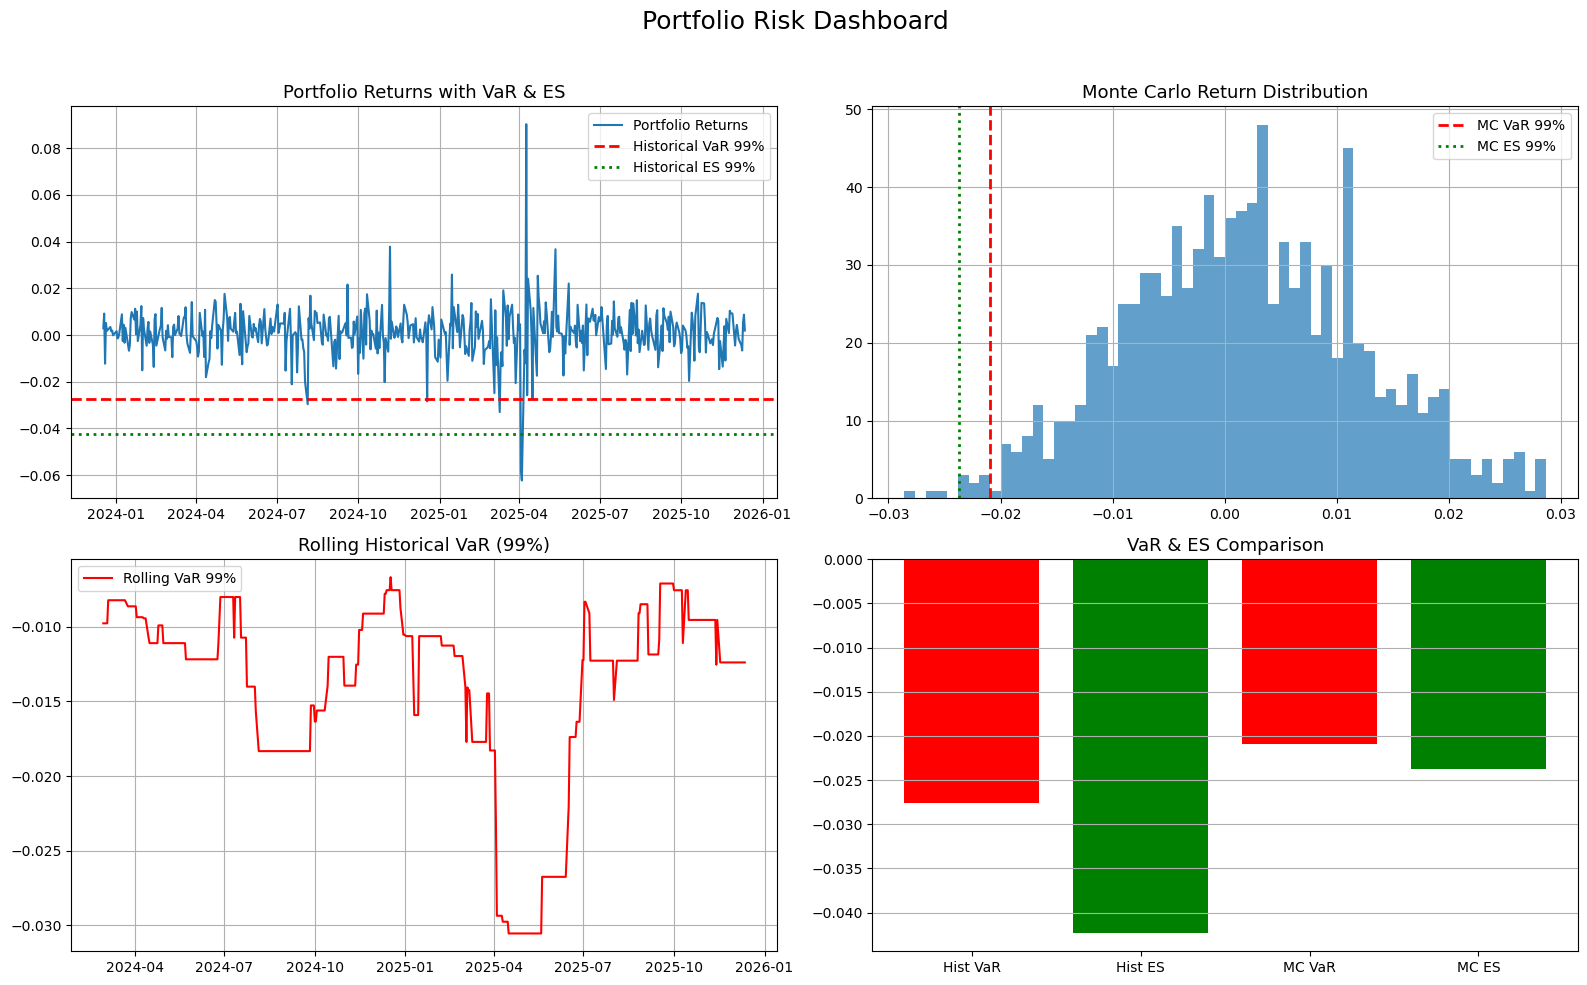

In [44]:
var_99 = historical_var(portfolio_returns, 0.99)
es_99 = historical_es(portfolio_returns, 0.99)

window = 50
rolling_var_99 = portfolio_returns.rolling(window).apply(lambda x: np.percentile(x, 5), raw=True)

fig, axes = plt.subplots(2, 2, figsize=(16,10))


# Panel 1 — Time Series + VaR

axes[0,0].plot(portfolio_returns, label="Portfolio Returns", linewidth=1.5)
axes[0,0].axhline(var_99, color="red", linestyle="--", linewidth=2, label=f"Historical VaR 99%")
axes[0,0].axhline(es_99, color="green", linestyle=":", linewidth=2, label=f"Historical ES 99%")
axes[0,0].set_title("Portfolio Returns with VaR & ES", fontsize=13)
axes[0,0].legend()
axes[0,0].grid(True)


# Panel 2 — Monte Carlo Histogram

axes[0,1].hist(sim_portfolio_returns, bins=60, alpha=0.7)
axes[0,1].axvline(var_mc_99, color="red", linestyle="--", linewidth=2, label="MC VaR 99%")
axes[0,1].axvline(es_mc_99, color="green", linestyle=":", linewidth=2, label="MC ES 99%")
axes[0,1].set_title("Monte Carlo Return Distribution", fontsize=13)
axes[0,1].legend()
axes[0,1].grid(True)


# Panel 3 — Rolling Historical VaR

axes[1,0].plot(rolling_var_99, color="red", linewidth=1.5, label="Rolling VaR 99%")
axes[1,0].set_title("Rolling Historical VaR (99%)", fontsize=13)
axes[1,0].legend()
axes[1,0].grid(True)


# Panel 4 — Side-by-side VaR vs ES

labels = ["Hist VaR", "Hist ES", "MC VaR", "MC ES"]
values = [var_99, es_99, var_mc_99, es_mc_99]
colors = ["red", "green", "red", "green"]

axes[1,1].bar(labels, values, color=colors)
axes[1,1].set_title("VaR & ES Comparison", fontsize=13)
axes[1,1].grid(axis="y")


# Overall layout
plt.suptitle("Portfolio Risk Dashboard", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

